# REMEMBER: throw out rows with null values needed to calculate the target

# Step 0: Imports and loading data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns
from scipy.stats import zscore, skew
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import xgboost
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', 500)

In [4]:
raw_data = pd.read_excel('Competition1_raw_data.xlsx')
data = raw_data.copy()

In [5]:
data.head(3)

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,10,9.5,8.5,11.87,122,1,3.43,0.0290743,40962052,10600000,51.345,470,12719,11560,301,690,62,117,139
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834,8,10,8,7.25,259,0,-1.62,-0.0133516,28869196,2400000,25.936,791,21792,19585,510,1120,71,242,237
2,ACAD,ACADIA PHARMACEUTICALS INC,2834,7,14,12,6.7,90,1,-1.24,0.020715,16845668,5000000,7.378,201,5262,4785,128,325,61,33,60


# Step 1: Identify the null values

In [6]:
for col in data.columns:
    data[col] = data[col].apply(lambda x: np.nan if x == '-' else x)

In [7]:
def data_validation(row):  
    '''
    Run initially, fix issues, then rerun until only nulls left
    
    Look at those which logically dont make sense and address them
    '''
    # If any nulls we know it's off
    ret_val = 0
    if row.isna().any():
        ret_val = 1
    
    # P(H) > P(L)
    #Higher range of price > lower range
    if row['P(H)'] < row['P(L)']:
        ret_val = 2
    
    # T4 < T1
    # Number of long sentences less than number of sentences
    elif row['T4'] > row['T1']:
        ret_val = 3
        
    # T3 < T2
    # Number of words > number of real words
    elif row['T3'] > row['T2']:
        ret_val = 4
        
    # T5 < T2
    # Number of long words < number of total words
    elif row['T5'] > row['T2']:
        ret_val = 5
        
    # T1 < T2
    # Number of words > number of sentences
    elif row['T1'] > row['T2']:
        ret_val = 6
    
    # C2, C3' in [0,1]
    # Defined as only being one of these two
    elif row['C2'] not in [0.0,1.0] and pd.notnull(row['C2']):
        ret_val = 7
    
    return ret_val
    

In [8]:
data['data_updated'] = data.apply(lambda row: data_validation(row), axis = 1)

In [9]:
data.data_updated.value_counts()

0    590
1     87
4      2
2      2
3      1
Name: data_updated, dtype: int64

In [10]:
data.loc[data['data_updated'] == 2, ['P(H)','P(L)']] = np.nan

In [11]:
data.loc[data['data_updated'] == 3, ['T4','T1']] = np.nan

In [12]:
data.loc[data['data_updated'] == 4, ['T3','T2']] = np.nan

In [13]:
data['data_updated'] = data.apply(lambda row: data_validation(row), axis = 1)

In [14]:
data.data_updated.value_counts()

0    590
1     91
4      1
Name: data_updated, dtype: int64

Row had more than one issue, run again to fix this

In [15]:
data.loc[data['data_updated'] == 4, ['T3','T2']] = np.nan

In [16]:
data['data_updated'] = data.apply(lambda row: data_validation(row), axis = 1)

In [17]:
data.data_updated.value_counts()

0    590
1     92
Name: data_updated, dtype: int64

Now only issue left is the null values which we can address through imputation and also have a column showing those which we need to fix in some way either through logic checks or imputation

# Step 2: Descriptive Statistics
- Mean/median/std/min/max/count/quartiles
- Missing Records
- Outlier Identification
    - Address Outliers
- Data Types/Fix data types

In [18]:
data.describe()

,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated
count,677.000000,670.000000,670.000000,660.000000,660.000000,660.000000,646.000000,660.000000,6.760000e+02,6.760000e+02,610.000000,680.000000,678.000000,678.000000,680.000000,681.000000,681.000000,681.000000,681.000000,682.000000
mean,13.837666,15.522925,13.527030,25.934766,149.728788,0.859091,1.788904,0.007282,4.935776e+07,1.241519e+07,500.459962,465.957353,12814.283186,11377.873156,294.264706,679.220264,68.421439,120.104258,144.759178,0.134897
std,6.053731,6.618732,5.839649,73.234948,152.817467,0.348192,162.666532,0.033318,1.043764e+08,2.512855e+07,1648.337634,175.668619,5396.780570,4833.321230,121.599795,472.914323,39.096525,84.828959,69.276285,0.341865
min,3.000000,4.000000,3.000000,0.000000,10.000000,0.000000,-786.239000,-0.162352,3.693227e+06,5.250000e+05,0.074000,132.000000,3271.000000,0.000000,0.000000,-1.000000,-1.000000,20.000000,26.000000,0.000000
25%,10.000000,13.000000,11.000000,11.000000,85.000000,1.000000,-0.852500,-0.013927,1.871417e+07,5.000000e+06,37.245750,351.750000,9213.250000,8135.000000,212.750000,462.000000,45.000000,73.000000,100.000000,0.000000
50%,13.500000,15.000000,13.000000,14.845000,107.000000,1.000000,0.010000,0.009125,2.740018e+07,7.398704e+06,103.833000,444.500000,12056.000000,10774.500000,279.000000,624.000000,60.000000,100.000000,134.000000,0.000000
75%,17.000000,17.000000,15.000000,20.485000,155.250000,1.000000,0.470000,0.031571,4.980786e+07,1.200000e+07,331.138000,551.250000,15243.250000,13712.000000,353.250000,795.000000,85.000000,142.000000,173.000000,0.000000
max,85.000000,135.000000,108.000000,1159.200562,2087.000000,1.000000,3864.500000,0.092896,2.138085e+09,4.212336e+08,30683.000000,1750.000000,49056.000000,43952.000000,1058.000000,10277.000000,309.000000,944.000000,883.000000,1.000000


Counts of null values

In [19]:
pd.isna(data).sum()

I1               0
I2               0
I3               8
P(IPO)           5
P(H)            12
P(L)            12
P(1Day)         22
C1              22
C2              22
C3              36
C4              22
C5               6
C6               6
C7              72
T1               2
T2               4
T3               4
T4               2
T5               1
S1               1
S2               1
S3               1
data_updated     0
dtype: int64

Data Types

In [20]:
data.dtypes

I1               object
I2               object
I3               object
P(IPO)          float64
P(H)            float64
P(L)            float64
P(1Day)         float64
C1              float64
C2              float64
C3              float64
C4              float64
C5              float64
C6              float64
C7              float64
T1              float64
T2              float64
T3              float64
T4              float64
T5              float64
S1              float64
S2              float64
S3              float64
data_updated      int64
dtype: object

Box Plots

Top level view

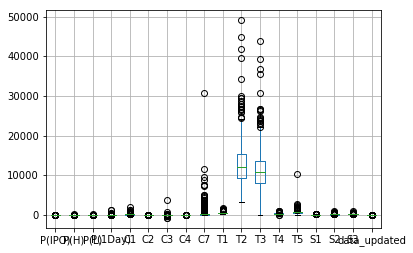

In [21]:
data[[i for i in data.columns if i not in ['I1','I2','I3','C5','C6']]].boxplot()
plt.show()

More specific per field

Seems to be a lot of strange data here, update those at far ends of the spectrum

# Step 3: Data Imputation
- Address null values dependent on the type of value in question
- Create a seperate column which shows whether or not imputation occurred

In [22]:
def impute_nulls_df(df, col, replace_val):
    '''
    params:
    
    df - dataframe containing nulls
    col - columns with nulls to replace
    replace_val - options: 'mean', 'median', 'mode'
    
    Example:

    imputed_data = impute_nulls(data, C1, 'mean')
    '''
    
    if replace_val not in ['mean','median','mode']:
        print('requires one of the following: mean, median, mode')
        return
    
    elif replace_val == 'mean':
        df[col + '_imputed'] = df[col].fillna(df[col].mean())
    elif replace_val == 'median':
        df[col + '_imputed'] = df[col].fillna(df[col].median())
    elif replace_val == 'mode':
        df[col + '_imputed'] = df[col].fillna(df[col].mode().values[0])
        
    return df

Create a dictionary for each value with the column and the type of imputation. Can then use a loop and the function above to impute them all.

Reminder of columns which need imputation

In [23]:
null_cols = pd.isna(data).sum()
null_cols = null_cols[null_cols.values != 0]
null_cols

I3          8
P(IPO)      5
P(H)       12
P(L)       12
P(1Day)    22
C1         22
C2         22
C3         36
C4         22
C5          6
C6          6
C7         72
T1          2
T2          4
T3          4
T4          2
T5          1
S1          1
S2          1
S3          1
dtype: int64

Look at histograms to get a better view of what to do for each

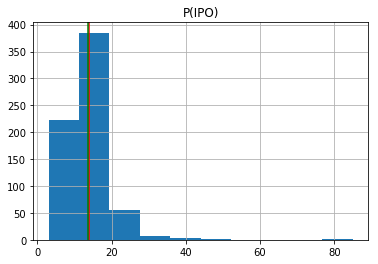

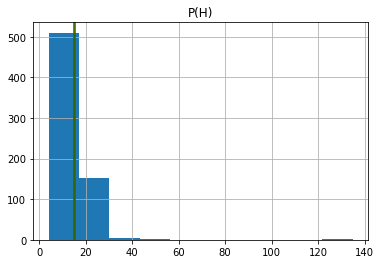

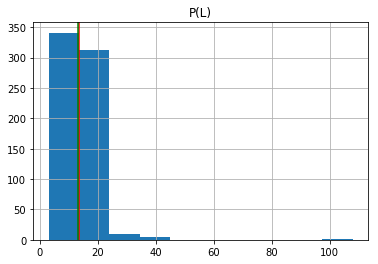

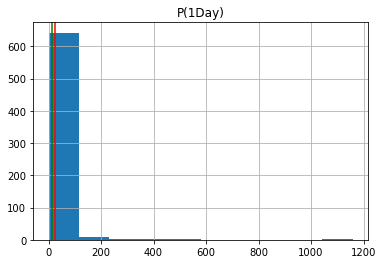

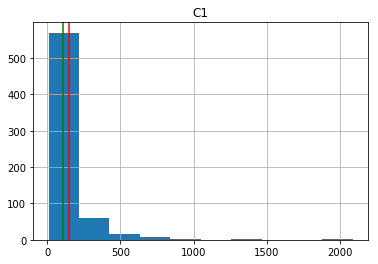

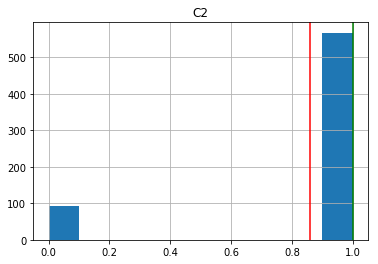

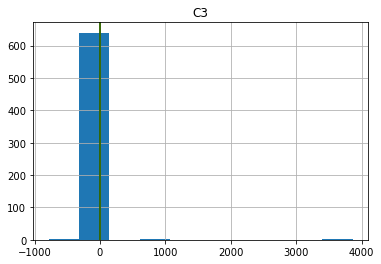

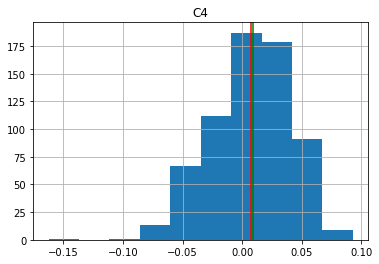

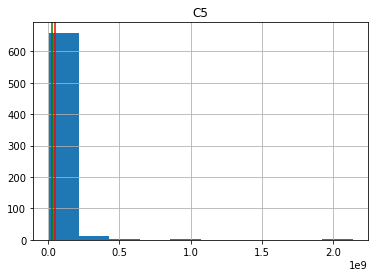

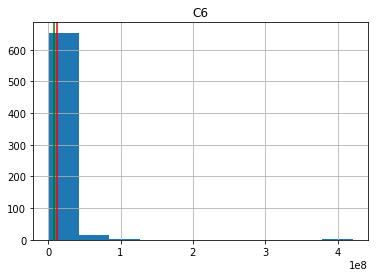

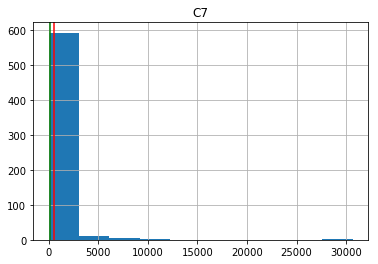

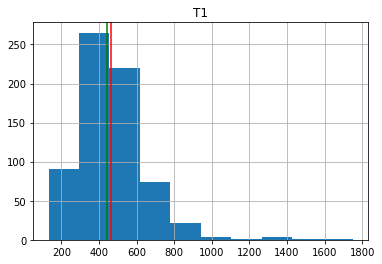

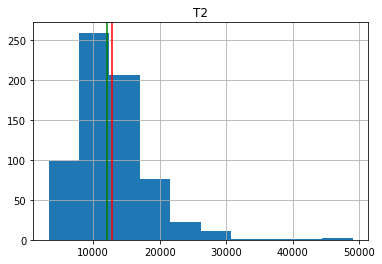

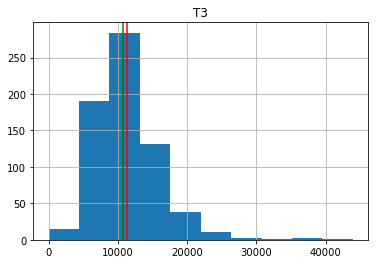

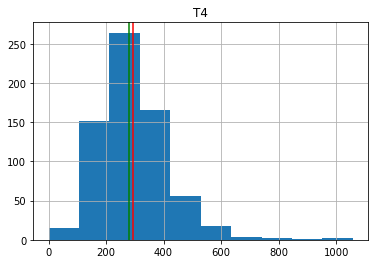

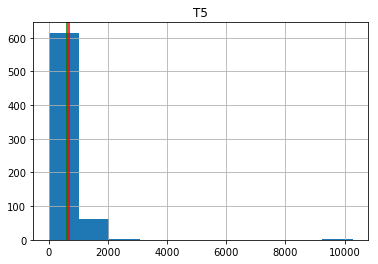

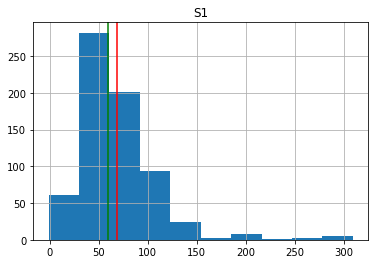

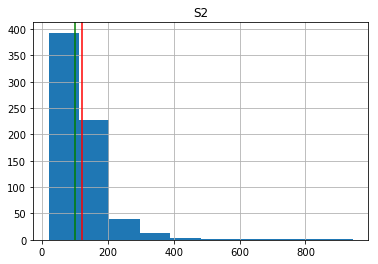

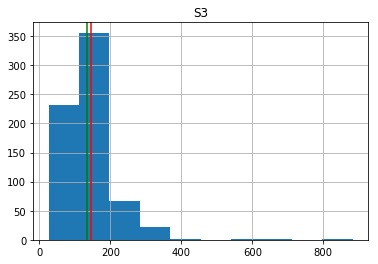

In [24]:
#Only plot numerical columns so drop non-numerical
for col in [i for i in list(null_cols.index) if i != 'I3']:
    #Create Histograms
    data[col].hist()
    #plt.xlabel(col)
    plt.title(col)
    plt.axvline(data[col].mean(), color = 'red')
    plt.axvline(data[col].median(), color = 'green')
    plt.show()

In [25]:
# There are a lot of heavy outliers in the dataset, so mean is used for many imputations

imputing = {
    'P(IPO)': 'mean',
    'P(H)': 'median',
    'P(L)': 'median',
    'P(1Day)': 'median',
    'C1': 'mean',
    'C2': 'mode', # categorical column
    'C3': 'median',
    'C4': 'mean',
    'C5': 'mean',
    'C6': 'mean',
    'C7': 'mean',
    'T1': 'mean',
    'T2': 'mean',
    'T3': 'mean',
    'T4': 'mean',
    'T5': 'mean',
    'S1': 'mean',
    'S2': 'mean',
    'S3': 'mean'
}

data_w_imputed = data.copy()

for key in imputing.keys():
    data_w_imputed = impute_nulls_df(data_w_imputed, key, imputing[key])

In [26]:
pd.isna(data_w_imputed).sum()

I1                  0
I2                  0
I3                  8
P(IPO)              5
P(H)               12
P(L)               12
P(1Day)            22
C1                 22
C2                 22
C3                 36
C4                 22
C5                  6
C6                  6
C7                 72
T1                  2
T2                  4
T3                  4
T4                  2
T5                  1
S1                  1
S2                  1
S3                  1
data_updated        0
P(IPO)_imputed      0
P(H)_imputed        0
P(L)_imputed        0
P(1Day)_imputed     0
C1_imputed          0
C2_imputed          0
C3_imputed          0
C4_imputed          0
C5_imputed          0
C6_imputed          0
C7_imputed          0
T1_imputed          0
T2_imputed          0
T3_imputed          0
T4_imputed          0
T5_imputed          0
S1_imputed          0
S2_imputed          0
S3_imputed          0
dtype: int64

Now there are new imputed columns at the end of the dataframe

In [27]:
data_w_imputed.head(3)

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated,P(IPO)_imputed,P(H)_imputed,P(L)_imputed,P(1Day)_imputed,C1_imputed,C2_imputed,C3_imputed,C4_imputed,C5_imputed,C6_imputed,C7_imputed,T1_imputed,T2_imputed,T3_imputed,T4_imputed,T5_imputed,S1_imputed,S2_imputed,S3_imputed
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,10.0,9.5,8.5,11.87,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0,0,10.0,9.5,8.5,11.87,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834,8.0,10.0,8.0,7.25,259.0,0.0,-1.62,-0.013352,28869196.0,2400000.0,25.936,791.0,21792.0,19585.0,510.0,1120.0,71.0,242.0,237.0,0,8.0,10.0,8.0,7.25,259.0,0.0,-1.62,-0.013352,28869196.0,2400000.0,25.936,791.0,21792.0,19585.0,510.0,1120.0,71.0,242.0,237.0
2,ACAD,ACADIA PHARMACEUTICALS INC,2834,7.0,14.0,12.0,6.70,90.0,1.0,-1.24,0.020715,16845668.0,5000000.0,7.378,201.0,5262.0,4785.0,128.0,325.0,61.0,33.0,60.0,0,7.0,14.0,12.0,6.70,90.0,1.0,-1.24,0.020715,16845668.0,5000000.0,7.378,201.0,5262.0,4785.0,128.0,325.0,61.0,33.0,60.0


# ******Peter Start Pipeline Here******

# Normalize

In [28]:
data_imputed = data_w_imputed.copy()

In [29]:
data_imputed.head(3)

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_updated,P(IPO)_imputed,P(H)_imputed,P(L)_imputed,P(1Day)_imputed,C1_imputed,C2_imputed,C3_imputed,C4_imputed,C5_imputed,C6_imputed,C7_imputed,T1_imputed,T2_imputed,T3_imputed,T4_imputed,T5_imputed,S1_imputed,S2_imputed,S3_imputed
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,10.0,9.5,8.5,11.87,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0,0,10.0,9.5,8.5,11.87,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834,8.0,10.0,8.0,7.25,259.0,0.0,-1.62,-0.013352,28869196.0,2400000.0,25.936,791.0,21792.0,19585.0,510.0,1120.0,71.0,242.0,237.0,0,8.0,10.0,8.0,7.25,259.0,0.0,-1.62,-0.013352,28869196.0,2400000.0,25.936,791.0,21792.0,19585.0,510.0,1120.0,71.0,242.0,237.0
2,ACAD,ACADIA PHARMACEUTICALS INC,2834,7.0,14.0,12.0,6.70,90.0,1.0,-1.24,0.020715,16845668.0,5000000.0,7.378,201.0,5262.0,4785.0,128.0,325.0,61.0,33.0,60.0,0,7.0,14.0,12.0,6.70,90.0,1.0,-1.24,0.020715,16845668.0,5000000.0,7.378,201.0,5262.0,4785.0,128.0,325.0,61.0,33.0,60.0


# Create Values Outlined in Data Dictionary
- T1-T5 as ratios
- S1-S3 as ratios
- C3', C5', C6'
- Y1, Y2
- Any additional that seem reasonable

Reference here: https://github.com/fairfield-university-ba545/project1-archana-s-team/blob/master/DataDictionary20190115.pdf

In [30]:
# Example Ratio, divide the column with the number of words and columns with number of sentences to get words per sentence
data_imputed['words_per_sentence_imputed'] = data_imputed.T2_imputed / data_imputed.T1_imputed
data_imputed['real_word_per_imputed'] = data_imputed.T3_imputed / data_imputed.T2_imputed
data_imputed['non_real_word_per_imputed'] = (data_imputed.T2_imputed - data_imputed.T3_imputed) / data_imputed.T2_imputed
data_imputed['short_sentences_imputed'] = data_imputed.T1_imputed - data_imputed.T4_imputed
data_imputed['short_sentences_per_imputed'] = data_imputed.short_sentences_imputed / data_imputed.T1_imputed
data_imputed['long_sentences_per_imputed'] = data_imputed.T4_imputed / data_imputed.T1_imputed

In [31]:
# Percentage of positive words by dividing count of positive words by total words
data_imputed['pos_words_percent_imputed'] = data_imputed.S1_imputed / (data_imputed.S1_imputed + 
                                                                       data_imputed.S2_imputed + data_imputed.S3_imputed)
data_imputed['neg_words_percent_imputed'] = data_imputed.S2_imputed / (data_imputed.S1_imputed + 
                                                                       data_imputed.S2_imputed + data_imputed.S3_imputed)
data_imputed['uncertain_words_percent_imputed'] = data_imputed.S3_imputed / (data_imputed.S1_imputed + 
                                                                             data_imputed.S2_imputed + 
                                                                             data_imputed.S3_imputed)

In [32]:
data_imputed['total_shares_imputed'] = data_imputed.C5_imputed + data_imputed.C6_imputed
data_imputed['sales_per_share_imputed'] = data_imputed.C7_imputed/data_imputed.total_shares_imputed

In [33]:
data_imputed['C3\'_imputed'] = data_imputed.C3_imputed.apply(lambda x: 1 if x>0 else 0)
data_imputed['C5\'_imputed'] = data_imputed['C5_imputed']/ data_imputed['C6_imputed']
data_imputed['P(mid)'] = (data_imputed['P(H)'] + data_imputed['P(L)'])/2
data_imputed['C6\'_imputed'] = (data_imputed['P(IPO)'] - data_imputed['P(mid)'])/data_imputed['P(mid)']*100
data_imputed['Y1'] = data_imputed.apply(lambda row: 1 if row['P(IPO)'] < row['P(mid)'] else 0, axis = 1)
data_imputed['Y2'] = data_imputed.apply(lambda row: 1 if row['P(IPO)'] < row['P(1Day)'] else 0, axis = 1)

SIC codes classified as follows, can be used for binning

<table class="wikitable sortable jquery-tablesorter">

<thead><tr>
<th class="headerSort" tabindex="0" role="columnheader button" title="Sort ascending">Range of SIC Codes
</th>
<th class="headerSort" tabindex="0" role="columnheader button" title="Sort ascending">Division
</th></tr></thead><tbody>
<tr>
<td>0100-0999
</td>
<td>Agriculture, Forestry and Fishing
</td></tr>
<tr>
<td>1000-1499
</td>
<td>Mining
</td></tr>
<tr>
<td>1500-1799
</td>
<td>Construction
</td></tr>
<tr>
<td>1800-1999
</td>
<td>not used
</td></tr>
<tr>
<td>2000-3999
</td>
<td>Manufacturing
</td></tr>
<tr>
<td>4000-4999
</td>
<td>Transportation, Communications, Electric, Gas and Sanitary service
</td></tr>
<tr>
<td>5000-5199
</td>
<td>Wholesale Trade
</td></tr>
<tr>
<td>5200-5999
</td>
<td>Retail Trade
</td></tr>
<tr>
<td>6000-6799
</td>
<td>Finance, Insurance and Real Estate
</td></tr>
<tr>
<td>7000-8999
</td>
<td>Services
</td></tr>
<tr>
<td>9100-9729
</td>
<td>Public Administration
</td></tr>
<tr>
<td>9900-9999
</td>
<td>Nonclassifiable
</td></tr></tbody><tfoot></tfoot></table>

In [34]:
def bin_sic(val):
    try:
        val = int(val)
    except Exception as e:
        return 'Other'
    if val <= 999:
        return 'Agriculture, Forestry and Fishing'
    if val <= 1499:
        return 'Mining'
    if val <= 1799:
        return 'Construction'
    if val <= 1999:
        return 'Other'
    if val <= 3999:
        return 'Manufacturing'
    if val <= 4999:
        return 'Transportation, Communications, Electric, Gas and Sanitary service'
    if val <= 5199:
        return 'Wholesale Trade'
    if val <= 5999:
        return 'Retail Trade'
    if val <= 6799:
        return 'Finance, Insurance and Real Estate'
    if val <= 8999:
        return 'Services'
    if val <= 9729:
        return 'Public Administration'
    return 'Other'

In [35]:
data_imputed['industry_bin'] = data_imputed['I3'].apply(bin_sic)
data_imputed['industry_bin'] = data_imputed['industry_bin'].astype('category')

# Normality Part 2

- Histogram
- Shapiro test for normality: a p-value of lower than 0.05 implies non-normal values

In [36]:
def check_normal_by_hist(df, col):
    '''
    Creates a histogram to view values to check normality
    
    params:
    df - DataFrame
    col - Columns of DataFrame you want to test
    
    return:
    Void, however will print a histogram
    
    '''
    df[col].hist()
    plt.title(col)
    plt.show()
    
def check_normal_by_shapiro(df, col):
    '''
    Runs the Shapiro normality test on the values from a dataframe
    
    params:
    df - DataFrame
    col - Columns of DataFrame you want to test
    
    return:
    tuple - (Test Statistic, p-value)
    
    A p-value lower than 0.05 implies the values are NOT normal
    
    '''
    
    return shapiro(df[col].values)

def check_skew(df, col):
    return skew(df[col])

def bad_skew(df, col_list):
    bad_ones = []
    skews = []
    for i in col_list:
        skw = skew(df[i])
        if (skw > 0.5) or (skw < -0.5):
            bad_ones.append(i)
            skews.append(skw)
    return bad_ones, skews

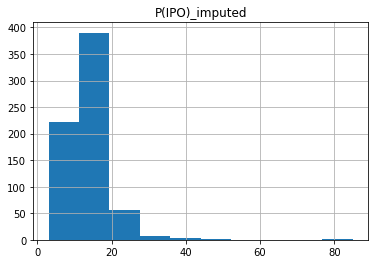

(0.8102320432662964, 1.4996843809499167e-27)
skew is 3.3950175252664994


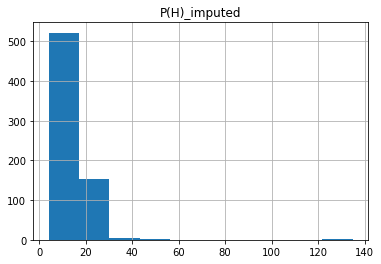

(0.5686391592025757, 6.86919309808954e-38)
skew is 9.464541685647873


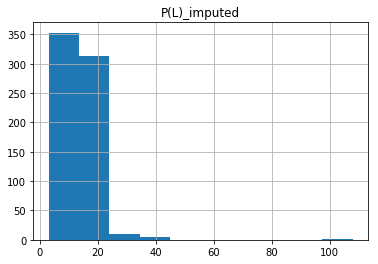

(0.6496447324752808, 4.1608080435856374e-35)
skew is 7.159331151261171


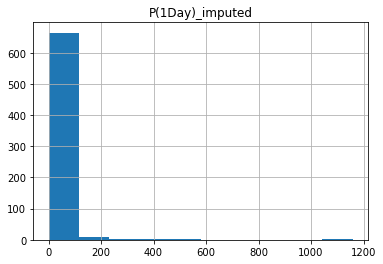

(0.17979323863983154, 0.0)
skew is 12.495039015655216


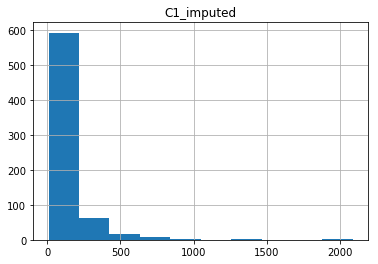

(0.5366458892822266, 7.148707300171482e-39)
skew is 5.72981096320028


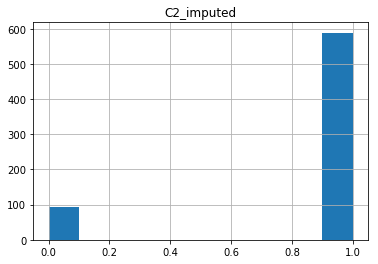

(0.40568774938583374, 2.1537957396672438e-42)
skew is -2.1192517713040706


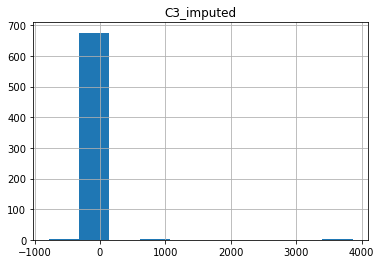

(0.0666353702545166, 0.0)
skew is 21.11220357833542


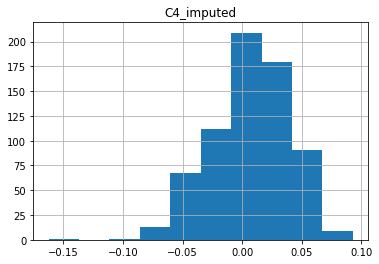

(0.9848333597183228, 1.618549049453577e-06)
skew is -0.48468727547433627


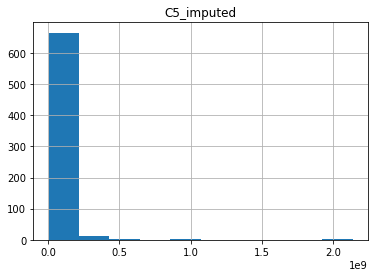

(0.27015477418899536, 1.401298464324817e-45)
skew is 13.631467843891096


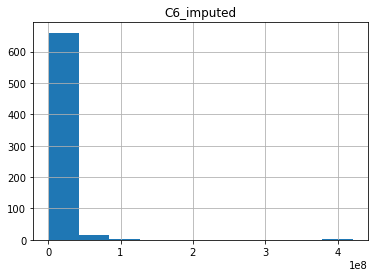

(0.2619563341140747, 1.401298464324817e-45)
skew is 12.58693418968681


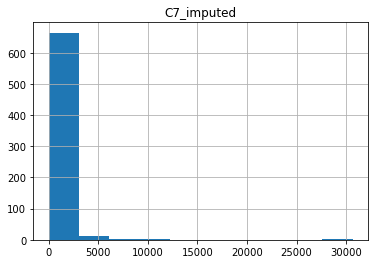

(0.26462793350219727, 1.401298464324817e-45)
skew is 12.355700256922756


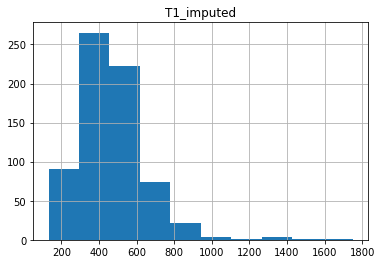

(0.9009252786636353, 1.368564022679162e-20)
skew is 1.7399411075754017


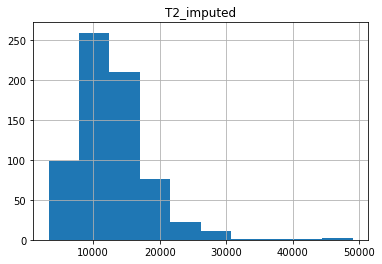

(0.8983656167984009, 7.645945441318744e-21)
skew is 1.7212580017911832


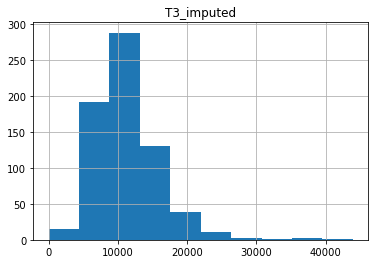

(0.907270610332489, 6.089528539970076e-20)
skew is 1.6319601611171242


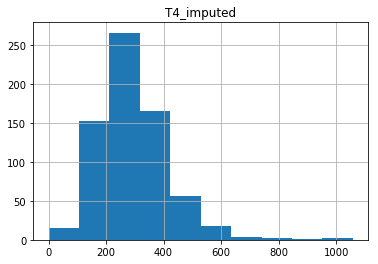

(0.9238683581352234, 4.468599654627335e-18)
skew is 1.4197739671875498


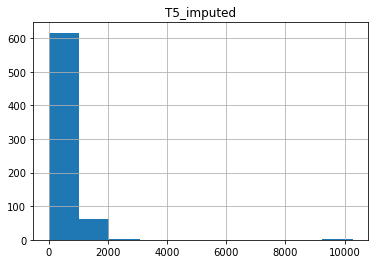

(0.4630507230758667, 6.139789221439186e-41)
skew is 12.744150646180715


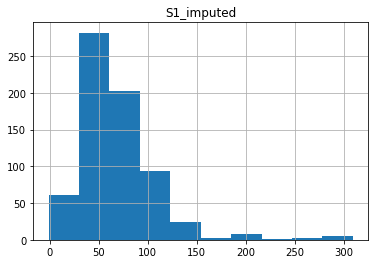

(0.8290369510650635, 2.3243957594916174e-26)
skew is 2.306986338155954


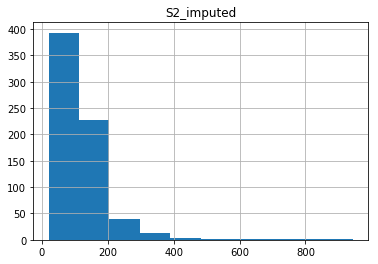

(0.7089569568634033, 1.0155094962069773e-32)
skew is 3.729074713680402


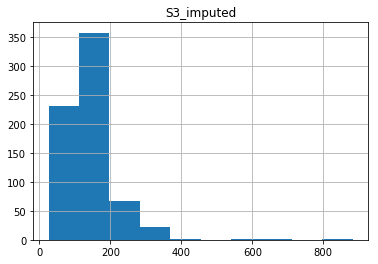

(0.7924658060073853, 1.3583232415548324e-28)
skew is 3.4322138412855754


In [37]:
for i in [j for j in data_imputed if 'imputed' in j][:19]:
    check_normal_by_hist(data_imputed, i)
    print(check_normal_by_shapiro(data_imputed, i))
    print('skew is ' + str(check_skew(data_imputed, i)))

In [38]:
for i in [j for j in data_imputed if 'standardized' in j]:
    check_normal_by_hist(data_imputed, i)
    print(check_normal_by_shapiro(data_imputed, i))
    print('skew is ' + str(check_skew(data_imputed, i)))

IQR Standardized look ALOT better than the others

In [39]:
bad_skew(data_imputed, [j for j in data_imputed if 'standardized' in j])

([], [])

# New Columns with Normalized values of non-normal fields
- Try applying squaring, log(), square root, 1/x function
- Leverage Histograms and Shapiro-Wilk test

In [40]:
def normalize_log(col_vals):
    return np.log(col_vals + min(col_vals))

def normalize_sqrt(col_vals):
    if min(col_vals) < 0:
        print('Can\'t sqrt with negative values')
        return
    return np.sqrt(col_vals)

def normalize_recip_sqrt(col_vals):
    if min(col_vals) < 0:
        print('Can\'t sqrt with negative values')
        return
    return 1/np.sqrt(col_vals)

def normalize_sigmoid(col_vals):
    return [1/(1+np.e**(-i)) for i in col_vals]

def normalize_div(col_vals):
    return 1/col_vals

def normalize_log_div(col_vals):
    return 1/np.log(col_vals + min(col_vals))

def normalize_shift_left(col_vals):
    return col_vals - len(col_vals)

def normalize_shift_right(col_vals):
    return col_vals + len(col_vals)

def normalize_by_power(col_vals):
    return [i**2 for i in col_vals]

def normalize_by_e(col_vals):
    return [np.e **(i + min(col_vals)) for i in col_vals]

def normalize_data(df, col, normalize_function = None):
    '''
    Given a dataframe, column, and type of normalization, attempt to make the field normal.
    
    params:
    df - dataframe
    col - string - column to normalize
    normalize_function - function - type of normalization to perform. If blank then all will be performed and compared.
        options are functions above
        
    '''
    
    if normalize_function is not None:
        try:
            new_vals = normalize_function(df[col].values)
            p_val = shapiro(new_vals)[1]
            valid = 'Normal' if p_val > 0.05 else 'Non-Normal'
            print('Shapiro Test says given function made the data ' + valid +' with a p-value of ' + str(p_val))
            if p_val > 0.05:
                plt.hist(new_vals)
                return True
            else:
                return False
        except Exception as e:
            print(e)    

In [41]:
[j for j in data_imputed if 'standardized' in j]

[]

In [42]:
normalize_data(data_imputed, 'P(IPO)_imputed_standardized', normalize_div)


'P(IPO)_imputed_standardized'


In [43]:
normalize_data(data_imputed, 'P(IPO)_imputed_standardized', normalize_by_e)


'P(IPO)_imputed_standardized'


In [44]:
normalize_data(data_imputed, 'P(IPO)_imputed_standardized', normalize_div)


'P(IPO)_imputed_standardized'


# Z-Score (if normal)


In [45]:
def z_score(df, col):
    df[col + '_zscore'] = df[col].apply(zscore)

Code For Z-Score

Replace with proper dataframe once normalized

In [46]:
data_stand = data_imputed.copy() 
for col in data_stand.drop(['I1','I2','I3'],axis=1).columns:
    print("Column: ", col)
    
    z_score(data_stand,col)
    print(data_stand[col + '_zscore'].head())
    
data_stand.drop(data.columns, axis=1)

Column:  P(IPO)


IndexError: tuple index out of range

# Standard Dev Standardization

In [ ]:
#Only plot numberical columns so drop non-numerical
 for col in data.drop(['I1','I2','I3'],axis=1).columns:
     print("Column: ", col)
    
     #Create Histograms
     data[col].hist()
     plt.xlabel(col)
     plt.title('Histogram')
     plt.show()
    
     #Find outliers within 3 standard deviations of mean
     outliers_low = (data[col].mean() - 3*data[col].std())
     outliers_high = (data[col].mean() + 3*data[col].std())
    
     #Print outlier values and counts of how many outliers
     print("outliers low value <", outliers_low)
     print("outlier low count: ", data[col][data[col] < outliers_low].count())
     print("outliers high value >", outliers_high) 
     print("outlier high count: ", data[col][data[col] > outliers_high].count())
     print('\n')

# ***** Peter End Pipeline Here*******

In [ ]:
scaling_tar = [i + '_std_scaled' for i in ['C1_imputed', 'C3_imputed',
       'C4_imputed', 'C5_imputed', 'C6_imputed', 'C7_imputed', 'T1_imputed',
       'T2_imputed', 'T3_imputed', 'T4_imputed', 'T5_imputed', 'S1_imputed',
       'S2_imputed', 'S3_imputed', 'C1_imputed_iqr_standardized',
       'C3_imputed_iqr_standardized', 'C4_imputed_iqr_standardized',
       'C5_imputed_iqr_standardized', 'C6_imputed_iqr_standardized',
       'C7_imputed_iqr_standardized', 'T1_imputed_iqr_standardized',
       'T2_imputed_iqr_standardized', 'T3_imputed_iqr_standardized',
       'T4_imputed_iqr_standardized', 'T5_imputed_iqr_standardized',
       'S1_imputed_iqr_standardized', 'S2_imputed_iqr_standardized',
       'S3_imputed_iqr_standardized',
       'words_per_sentence_imputed', 'real_word_per_imputed',
       'non_real_word_per_imputed', 'short_sentences_imputed', 'pos_words_percent_imputed',
       'neg_words_percent_imputed', 'uncertain_words_percent_imputed', 'total_shares_imputed',
       'sales_per_share_imputed', 'C5\'_imputed', 'C6\'_imputed',
       'words_per_sentence_imputed_iqr_standardized', 'real_word_per_imputed_iqr_standardized',
       'non_real_word_per_imputed_iqr_standardized', 'short_sentences_imputed_iqr_standardized', 'pos_words_percent_imputed_iqr_standardized',
       'neg_words_percent_imputed_iqr_standardized', 'uncertain_words_percent_imputed_iqr_standardized', 'total_shares_imputed_iqr_standardized',
       'sales_per_share_imputed_iqr_standardized', 'C5\'_imputed_iqr_standardized', 'C6\'_imputed_iqr_standardized']]

In [ ]:
scale = preprocessing.StandardScaler()

data_imputed_iqr = data_imputed_iqr.reindex(columns=data_imputed_iqr.columns.tolist() + scaling_tar)
data_imputed_iqr[scaling_tar] = scale.fit_transform(data_imputed_iqr[['C1_imputed', 'C3_imputed',
       'C4_imputed', 'C5_imputed', 'C6_imputed', 'C7_imputed', 'T1_imputed',
       'T2_imputed', 'T3_imputed', 'T4_imputed', 'T5_imputed', 'S1_imputed',
       'S2_imputed', 'S3_imputed', 'C1_imputed_iqr_standardized',
       'C3_imputed_iqr_standardized', 'C4_imputed_iqr_standardized',
       'C5_imputed_iqr_standardized', 'C6_imputed_iqr_standardized',
       'C7_imputed_iqr_standardized', 'T1_imputed_iqr_standardized',
       'T2_imputed_iqr_standardized', 'T3_imputed_iqr_standardized',
       'T4_imputed_iqr_standardized', 'T5_imputed_iqr_standardized',
       'S1_imputed_iqr_standardized', 'S2_imputed_iqr_standardized',
       'S3_imputed_iqr_standardized',
       'words_per_sentence_imputed', 'real_word_per_imputed',
       'non_real_word_per_imputed', 'short_sentences_imputed', 'pos_words_percent_imputed',
       'neg_words_percent_imputed', 'uncertain_words_percent_imputed', 'total_shares_imputed',
       'sales_per_share_imputed', 'C5\'_imputed', 'C6\'_imputed',
       'words_per_sentence_imputed_iqr_standardized', 'real_word_per_imputed_iqr_standardized',
       'non_real_word_per_imputed_iqr_standardized', 'short_sentences_imputed_iqr_standardized', 'pos_words_percent_imputed_iqr_standardized',
       'neg_words_percent_imputed_iqr_standardized', 'uncertain_words_percent_imputed_iqr_standardized', 'total_shares_imputed_iqr_standardized',
       'sales_per_share_imputed_iqr_standardized', 'C5\'_imputed_iqr_standardized', 'C6\'_imputed_iqr_standardized']])

# Step 8B: Data Standardization (Categorical)
- Identify viable categories (create as few as possible)
- One-hot-encode if needed

In [ ]:
data_imputed_iqr.head()

Current Categorical: C2_imputed, C3', industry_bin
- check how many classes for each and try to resolve it to be ~5 for each

In [ ]:
data_imputed_iqr.C2_imputed.value_counts()

In [ ]:
data_imputed_iqr['C3\'_imputed'].value_counts()

In [ ]:
data_imputed_iqr['C3\'_imputed_iqr_standardized'].value_counts()

In [ ]:
data_imputed_iqr.industry_bin.value_counts()

Industry bin seems to be the only one that needs to be adjusted

Combinations:
- Trade = wholesale trade and retail trade
- Add bottom 3 (Finance, Insurance and Real Estate | Construction | Agriculture, Forestry and Fishing to other)
- Add Mining to Other

In [ ]:
def combine_industry_col(val):
    if val in ['Mining','Finance, Insurance and Real Estate', 'Construction', 'Agriculture, Forestry and Fishing']:
        return 'Other'
    elif val == 'Mining':
        return 'Other'
    elif val in ['Retail Trade','Wholesale Trade']:
        return 'Trade'
    else:
        return val

In [ ]:
data_imputed_iqr['industry_bin'] = data_imputed_iqr.industry_bin.apply(combine_industry_col)

In [ ]:
def one_hot_encode(df, col):
    return pd.get_dummies(df[col], prefix = col + '_')

# Step 7: Correlation of input variables
- Line plot to display correlation
- HeatMap to check correlation

In [ ]:
corr = data_imputed_iqr.corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
data_imputed_iqr.head()

In [ ]:
imputed_only = ['P(IPO)_imputed', 'P(H)_imputed', 'P(L)_imputed',
       'P(1Day)_imputed', 'C1_imputed', 'C2_imputed', 'C3_imputed',
       'C4_imputed', 'C5_imputed', 'C6_imputed', 'C7_imputed', 'T1_imputed',
       'T2_imputed', 'T3_imputed', 'T4_imputed', 'T5_imputed', 'S1_imputed',
       'S2_imputed', 'S3_imputed', 'real_word_per_imputed',
       'non_real_word_per_imputed', 'short_sentences_imputed', 'pos_words_percent_imputed',
       'neg_words_percent_imputed', 'uncertain_words_percent_imputed', 'total_shares_imputed',
       'sales_per_share_imputed', 'C3\'_imputed', 'C5\'_imputed', 'P(mid)', 'C6\'_imputed', 'Y1', 'Y2',
       'industry_bin']

iqr_standardized_only = ['P(IPO)_imputed_iqr_standardized',
       'P(H)_imputed_iqr_standardized', 'P(L)_imputed_iqr_standardized',
       'P(1Day)_imputed_iqr_standardized', 'C1_imputed_iqr_standardized',
       'C3_imputed_iqr_standardized', 'C4_imputed_iqr_standardized',
       'C5_imputed_iqr_standardized', 'C6_imputed_iqr_standardized',
       'C7_imputed_iqr_standardized', 'T1_imputed_iqr_standardized',
       'T2_imputed_iqr_standardized', 'T3_imputed_iqr_standardized',
       'T4_imputed_iqr_standardized', 'T5_imputed_iqr_standardized',
       'S1_imputed_iqr_standardized', 'S2_imputed_iqr_standardized',
       'S3_imputed_iqr_standardized', 'words_per_sentence_imputed_iqr_standardized', 'real_word_per_imputed_iqr_standardized',
       'non_real_word_per_imputed_iqr_standardized', 'short_sentences_imputed_iqr_standardized', 'pos_words_percent_imputed_iqr_standardized',
       'neg_words_percent_imputed_iqr_standardized', 'uncertain_words_percent_imputed_iqr_standardized', 'total_shares_imputed_iqr_standardized',
       'sales_per_share_imputed_iqr_standardized', 'C3\'_imputed_iqr_standardized', 'C5\'_imputed_iqr_standardized', 'P(mid)', 'C6\'_imputed_iqr_standardized', 'Y1', 'Y2',
       'industry_bin']

In [ ]:
corr = data_imputed_iqr[imputed_only].corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
corr = data_imputed_iqr[iqr_standardized_only].corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Step 9: Identify and remove redundunt information
- Leverage correlation analysis
- RFE (recursive feature elimination) to select valuable items
- JointPlots against target

# Methodology 
- There will be a few different ways of representing the same information
    - IQR updated
    - Normalized
    - Scaled
- Take each of these in RFE to pick a "winner"
- Keep only the "winners" and use these in PCA

Only test fields intented for final results (nothing used in other features created, nothing relating to target variable)

In [ ]:
for i in list(data_imputed_iqr.columns):
    if 'std_scaled' in i: print(i)

In [ ]:
def get_important_features_rfe(xTrain, yTrain, num_feats):
    '''
    Takes training values and returns the most important features in order
    '''
    clf = LogisticRegression()
    selector = RFE(clf, num_feats, step=1)
    selector.fit(xTrain, yTrain)
    
    return [x for _,x in sorted(zip(selector.ranking_, list(xTrain.columns)))]
    
    

In [ ]:
test_feats = {
    'C1': ['C1_imputed_std_scaled', 'C1_imputed_iqr_standardized_std_scaled'],
    'C2': ['C2_imputed'],
    'C3': ['C3\'_imputed','C3\'_imputed_iqr_standardized'],
    'C4': ['C4_imputed_std_scaled', 'C4_imputed_iqr_standardized_std_scaled'],
    #'C5': ['C5_imputed_std_scaled', 'C5_imputed_iqr_standardized_std_scaled'],
    #'C6': ['C6_imputed_std_scaled', 'C6_imputed_iqr_standardized_std_scaled'],
    #'C7': ['C7_imputed_std_scaled', 'C7_imputed_iqr_standardized_std_scaled'],
    'words_per_sentence': ['words_per_sentence_imputed_std_scaled', 'words_per_sentence_imputed_iqr_standardized_std_scaled'],
    'real_words': ['real_word_per_imputed_std_scaled','real_word_per_imputed_iqr_standardized_std_scaled'],
    'non_real_words': ['non_real_word_per_imputed_std_scaled','non_real_word_per_imputed_iqr_standardized_std_scaled'],
    'short_sent': ['short_sentences_imputed_std_scaled', 'short_sentences_imputed_iqr_standardized_std_scaled'],
    'pos_words_per': ['pos_words_percent_imputed_std_scaled','pos_words_percent_imputed_iqr_standardized_std_scaled'],
    'neg_word_per': ['neg_words_percent_imputed_std_scaled', 'neg_words_percent_imputed_iqr_standardized_std_scaled'],
    'uncertain_word_per': ['uncertain_words_percent_imputed_std_scaled','uncertain_words_percent_imputed_iqr_standardized_std_scaled'],
    'total_shares': ['total_shares_imputed_std_scaled','total_shares_imputed_iqr_standardized_std_scaled'],
    'sales_per_share': ['sales_per_share_imputed_std_scaled','sales_per_share_imputed_iqr_standardized_std_scaled'],
    'C5\'': ['C5\'_imputed_std_scaled', 'C5\'_imputed_iqr_standardized_std_scaled'],
    'C6\'': ['C6\'_imputed_std_scaled', 'C6\'_imputed_iqr_standardized_std_scaled'],
    
}

In [ ]:
picked_feats = dict.fromkeys(test_feats.keys(), '')

In [ ]:
data_imputed_iqr[test_feats['C6\'']].isna().sum()

# TEMP FIX OF ALTERING C6'

In [ ]:
data_imputed_iqr['C6\'_imputed_std_scaled'].fillna(0, inplace = True)
data_imputed_iqr['C6\'_imputed_iqr_standardized_std_scaled'].fillna(0, inplace = True)

In [ ]:
for i in test_feats.keys():
    if len(test_feats[i]) == 1:
        picked_feats[i] = test_feats[i][0]
    else:
        #print(i)
        xTrain = data_imputed_iqr[test_feats[i]]
        yTrain = data_imputed_iqr.Y1
        yTrain_alt = data_imputed_iqr.Y2
        picked_feats[i] = get_important_features_rfe(xTrain, yTrain, 1)[0]
        


In [ ]:
picked_feats

In [ ]:
for i in picked_feats.values():
    if data_imputed_iqr[i].isnull().sum() > 0:
        print(i)

In [ ]:
data_imputed_iqr.C2_imputed.sort_values()

In [ ]:
pca = PCA(.95)
pca.fit(data_imputed_iqr[list(picked_feats.values())])

# Step 9B: Balance Sample Data
- SMOTE
- Split Data

# Step 10: Test against sample code
- Test as-is to get baseline for AUC and F1 score
- Test different scaled data
- Test all data vs what we deem should be removed

# Step 11: Look at model specifics to seek room for improvement:
- Coefficiants of remaining fields
- Look at items with highest error rate and see if we can fit them to a class

# Step 12: Alternative Modeling techniques
- Random Forest
- Potentially XGBoost
- See if either of this yields better results